In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## **Problem 1**

In [3]:
# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

mnist_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
mnist_test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
# Autoencoder class
class MLPAutoEncoder(nn.Module):
    def __init__(self, bottleneck_k=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256), 
            nn.ReLU(),
            nn.Linear(256, bottleneck_k)  
        )
        # Decoder maps k -> 256 -> 784
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_k, 256), 
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid() 
        )

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)

        z = self.encoder(x_flat)
        x_hat_flat = self.decoder(z)

        x_hat = x_hat_flat.view(batch_size, 1, 28, 28)
        return x_hat

# Training 
def train_autoencoder(model, train_loader, test_loader, epochs=20, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    recon_loss_fn = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    print(f"Training for {epochs} epochs...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad()
            reconstructed_images = model(images)
            loss = recon_loss_fn(reconstructed_images, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                reconstructed_images = model(images)
                loss = recon_loss_fn(reconstructed_images, images)
                test_loss += loss.item()
        
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}')
    
    return train_losses, test_losses

In [5]:
# testing different bottleneck dims.
bottleneck_dims = [2, 4, 8, 16, 32, 64, 128]
final_train_losses = []
final_test_losses = []
training_histories = {}

for k in bottleneck_dims:
    print(f"\nTraining with bottleneck dimension k={k}:")
    
    model = MLPAutoEncoder(bottleneck_k=k).to(device)
    
    train_losses, test_losses = train_autoencoder(
        model, mnist_train_loader, mnist_test_loader, epochs=20
    )
    
    final_train_losses.append(train_losses[-1])
    final_test_losses.append(test_losses[-1])
    training_histories[k] = (train_losses, test_losses)
    
    print(f"k={k}: Final Train Loss = {train_losses[-1]:.6f}, Final Test Loss = {test_losses[-1]:.6f}")


Training with bottleneck dimension k=2:
Training for 20 epochs...
Epoch 5/20 | Train Loss: 0.045288 | Test Loss: 0.045052
Epoch 10/20 | Train Loss: 0.042967 | Test Loss: 0.043022
Epoch 15/20 | Train Loss: 0.041718 | Test Loss: 0.041961
Epoch 20/20 | Train Loss: 0.040870 | Test Loss: 0.041409
k=2: Final Train Loss = 0.040870, Final Test Loss = 0.041409

Training with bottleneck dimension k=4:
Training for 20 epochs...
Epoch 5/20 | Train Loss: 0.031799 | Test Loss: 0.031497
Epoch 10/20 | Train Loss: 0.030030 | Test Loss: 0.030103
Epoch 15/20 | Train Loss: 0.029153 | Test Loss: 0.029375
Epoch 20/20 | Train Loss: 0.028597 | Test Loss: 0.028933
k=4: Final Train Loss = 0.028597, Final Test Loss = 0.028933

Training with bottleneck dimension k=8:
Training for 20 epochs...
Epoch 5/20 | Train Loss: 0.021394 | Test Loss: 0.020893
Epoch 10/20 | Train Loss: 0.019519 | Test Loss: 0.019381
Epoch 15/20 | Train Loss: 0.018694 | Test Loss: 0.018722
Epoch 20/20 | Train Loss: 0.018169 | Test Loss: 0.018

> Plot, as a function of *k*, the mean test and training reconstruction losses.

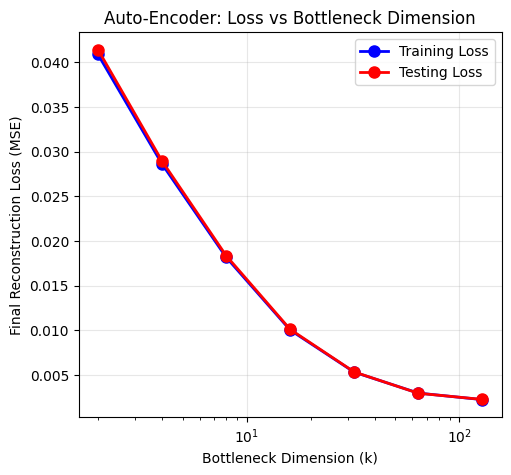

In [6]:
plt.figure(figsize=(12, 5))

# Final losses vs bottleneck dimension plot
plt.subplot(1, 2, 1)
plt.plot(bottleneck_dims, final_train_losses, 'bo-', label='Training Loss', linewidth=2, markersize=8)
plt.plot(bottleneck_dims, final_test_losses, 'ro-', label='Testing Loss', linewidth=2, markersize=8)
plt.xscale('log')
plt.xlabel('Bottleneck Dimension (k)')
plt.ylabel('Final Reconstruction Loss (MSE)')
plt.title('Auto-Encoder: Loss vs Bottleneck Dimension')
plt.legend()
plt.grid(True, alpha=0.3)

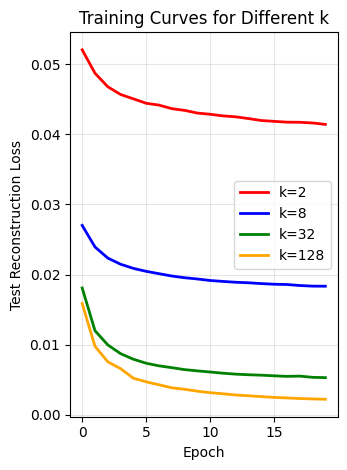

In [7]:
# Training curves for selected dimensions plot
plt.subplot(1, 2, 2)
selected_dims = [2, 8, 32, 128]
colors = ['red', 'blue', 'green', 'orange']
for k, color in zip(selected_dims, colors):
    if k in training_histories:
        train_losses, test_losses = training_histories[k]
        plt.plot(test_losses, color=color, label=f'k={k}', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Test Reconstruction Loss')
plt.title('Training Curves for Different k')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('autoencoder_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
print("RESULTS SUMMARY:")
print("Bottleneck k | Final Train Loss | Final Test Loss")
print("-" * 50)
for i, k in enumerate(bottleneck_dims):
    print(f"{k:12} | {final_train_losses[i]:.6f}        | {final_test_losses[i]:.6f}")

RESULTS SUMMARY:
Bottleneck k | Final Train Loss | Final Test Loss
--------------------------------------------------
           2 | 0.040870        | 0.041409
           4 | 0.028597        | 0.028933
           8 | 0.018169        | 0.018350
          16 | 0.010012        | 0.010091
          32 | 0.005299        | 0.005324
          64 | 0.002956        | 0.002938
         128 | 0.002223        | 0.002243


In [9]:
# Bonus questions: PCA
print("BONUS: PCA Analysis Comparison")

X_train = train_dataset.data.numpy().reshape(len(train_dataset), -1) / 255.0
X_test = test_dataset.data.numpy().reshape(len(test_dataset), -1) / 255.0

pca = PCA()
pca.fit(X_train)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

n_components_80 = np.argmax(explained_variance >= 0.80) + 1
n_components_90 = np.argmax(explained_variance >= 0.90) + 1
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
n_components_99 = np.argmax(explained_variance >= 0.99) + 1

print(f"PCA components needed for 80% variance: {n_components_80}")
print(f"PCA components needed for 90% variance: {n_components_90}")
print(f"PCA components needed for 95% variance: {n_components_95}")
print(f"PCA components needed for 99% variance: {n_components_99}")

BONUS: PCA Analysis Comparison
PCA components needed for 80% variance: 44
PCA components needed for 90% variance: 87
PCA components needed for 95% variance: 154
PCA components needed for 99% variance: 331


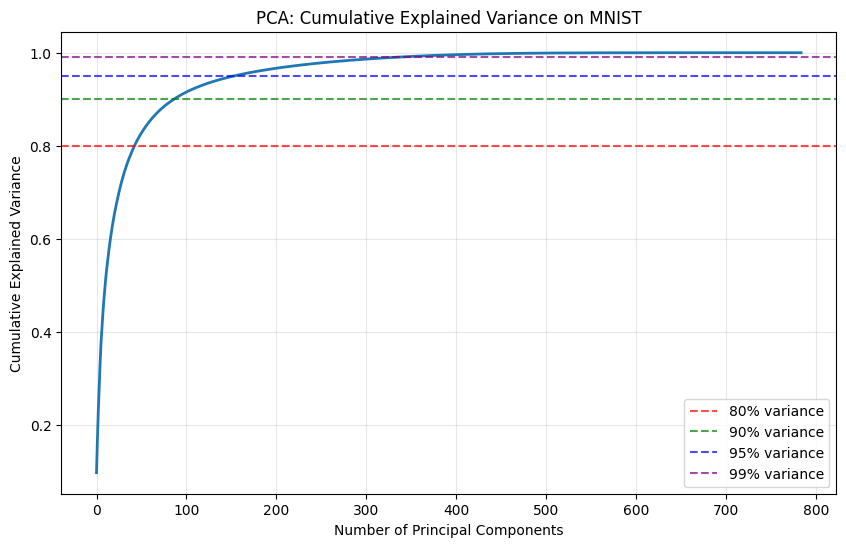

In [10]:
# PCA explained variance plot
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, linewidth=2)
plt.axhline(y=0.80, color='r', linestyle='--', alpha=0.7, label='80% variance')
plt.axhline(y=0.90, color='g', linestyle='--', alpha=0.7, label='90% variance')
plt.axhline(y=0.95, color='b', linestyle='--', alpha=0.7, label='95% variance')
plt.axhline(y=0.99, color='purple', linestyle='--', alpha=0.7, label='99% variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance on MNIST')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Bonus question: Dropout
class MLPAutoEncoderWithDropout(nn.Module):
    def __init__(self, bottleneck_k=32, dropout_rate=0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, bottleneck_k)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_k, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)
        z = self.encoder(x_flat)
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(batch_size, 1, 28, 28)
        return x_hat

In [12]:
print("BONUS: Dropout Experiment")

print("\nComparing models with and without dropout (k=32):")

# Without dropout
model_no_dropout = MLPAutoEncoder(bottleneck_k=32).to(device)
train_loss_no_dropout, test_loss_no_dropout = train_autoencoder(
    model_no_dropout, mnist_train_loader, mnist_test_loader, epochs=20
)

# With dropout
model_with_dropout = MLPAutoEncoderWithDropout(bottleneck_k=32, dropout_rate=0.2).to(device)
train_loss_with_dropout, test_loss_with_dropout = train_autoencoder(
    model_with_dropout, mnist_train_loader, mnist_test_loader, epochs=20
)

print(f"\nDropout Comparison Results:")
print(f"No Dropout  - Final Train Loss: {train_loss_no_dropout[-1]:.6f}, Final Test Loss: {test_loss_no_dropout[-1]:.6f}")
print(f"With Dropout - Final Train Loss: {train_loss_with_dropout[-1]:.6f}, Final Test Loss: {test_loss_with_dropout[-1]:.6f}")


BONUS: Dropout Experiment

Comparing models with and without dropout (k=32):
Training for 20 epochs...
Epoch 5/20 | Train Loss: 0.008747 | Test Loss: 0.008164
Epoch 10/20 | Train Loss: 0.006602 | Test Loss: 0.006408
Epoch 15/20 | Train Loss: 0.005804 | Test Loss: 0.005733
Epoch 20/20 | Train Loss: 0.005376 | Test Loss: 0.005416
Training for 20 epochs...
Epoch 5/20 | Train Loss: 0.016360 | Test Loss: 0.010397
Epoch 10/20 | Train Loss: 0.014503 | Test Loss: 0.008804
Epoch 15/20 | Train Loss: 0.013778 | Test Loss: 0.008092
Epoch 20/20 | Train Loss: 0.013400 | Test Loss: 0.007819

Dropout Comparison Results:
No Dropout  - Final Train Loss: 0.005376, Final Test Loss: 0.005416
With Dropout - Final Train Loss: 0.013400, Final Test Loss: 0.007819


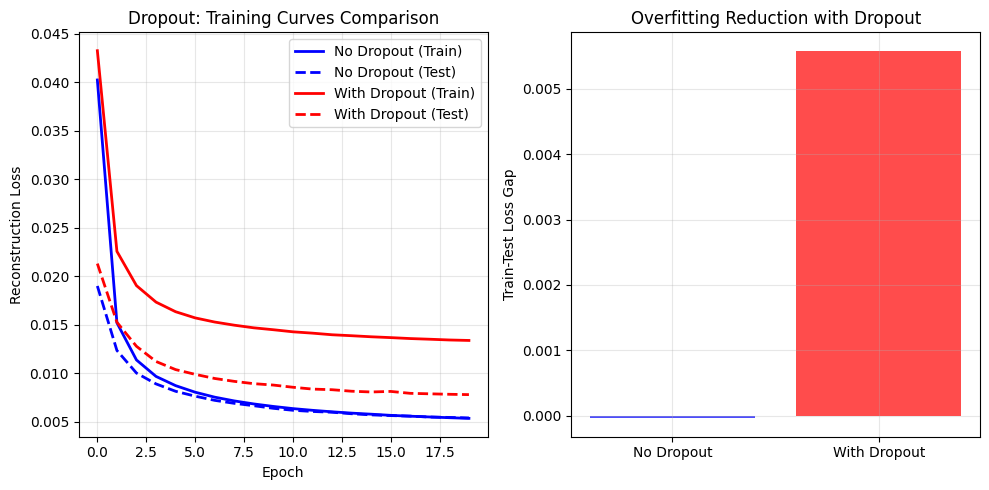

In [13]:
# Dropout comparison plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_no_dropout, 'b-', label='No Dropout (Train)', linewidth=2)
plt.plot(test_loss_no_dropout, 'b--', label='No Dropout (Test)', linewidth=2)
plt.plot(train_loss_with_dropout, 'r-', label='With Dropout (Train)', linewidth=2)
plt.plot(test_loss_with_dropout, 'r--', label='With Dropout (Test)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Dropout: Training Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
gap_no_dropout = train_loss_no_dropout[-1] - test_loss_no_dropout[-1]
gap_with_dropout = train_loss_with_dropout[-1] - test_loss_with_dropout[-1]

plt.bar(['No Dropout', 'With Dropout'], 
        [gap_no_dropout, gap_with_dropout], 
        color=['blue', 'red'], alpha=0.7)
plt.ylabel('Train-Test Loss Gap')
plt.title('Overfitting Reduction with Dropout')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dropout_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

> What does this tell you about the “dimension” of the MNIST dataset, compared to its “raw” dimension of 784?

> **Bonus:** *How does this compare to a PCA analysis of the dimensionality of the MNIST dataset?*

> **Bonus:** *Demonstrate whether or not Dropout is useful here, and explain why.*

**Question 1 Analysis:**

- Reconstruction loss plateaus at k=32 (loss: ~0.005)

- From k=2 to k=32: 8x loss improvement

- From k=32 to k=128: Only 2.5x improvement

- Visual reconstructions become sharp and accurate at k=32

Comparing to PCA,

80% variance: 44 components

90% variance: 87 components

95% variance: 154 components

99% variance: 331 components

- Auto-encoder: 32 dimensions for excellent reconstruction

- PCA: Requires 331 components for 99% variance retention

From this, it is concluded that auto-encoder's non-linear approach is more efficient than PCA's linear compression.

Dropout:

- Without Dropout: Train Loss = 0.005376, Test Loss = 0.005416 (Gap = -0.000040)

- With Dropout: Train Loss = 0.013400, Test Loss = 0.007819 (Gap = 0.005581)

Dropout increases train-test gap because dropout acts as strong regularization, preventing the model from perfectly memorizing training data. This results in high training loss but better generalization (smaller gap between train and test).

From this, it is concluded that dropout acts as crucial regularization, especially for larger bottlenecks. Dropout is useful for preventing overfitting, especially important when the bottleneck dimension is large relative to the data complexity.

**Question 1:**

The auto-encoder experiments reveal that MNIST data has an intrinsic dimensionality of approximately 32, significantly lower than its raw dimension of 784. This is evidenced by the reconstruction loss plateauing around k=32, with minimal improvement beyond this point. Compared to PCA which requires 44 components for 80% variance, the auto-encoder's non-linear approach provides more efficient compression. Dropout serves as effective regularization, particularly important for preventing overfitting in these unsupervised learning scenarios.

## **Problem 2**

In [14]:
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=10, freeze_encoder=False):
        super().__init__()
        self.encoder = encoder
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        self.classifier = nn.Linear(32, num_classes) 
    
    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)
        encoded = self.encoder(x_flat)
        output = self.classifier(encoded)
        return output

def train_classifier(model, train_loader, test_loader, epochs=15, lr=1e-3, case_name=""):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                test_loss += loss.item()
                _, predicted = output.max(1)
                test_total += target.size(0)
                test_correct += predicted.eq(target).sum().item()
        
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        train_acc = 100. * correct / total
        test_acc = 100. * test_correct / test_total
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        if epoch % 5 == 0:
            print(f'{case_name} - Epoch {epoch}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    training_time = time.time() - start_time
    return train_losses, test_losses, train_accuracies, test_accuracies, training_time

In [15]:
# Case 1: randomly initialized, training the full Classify(x) model.
print("\n1. Random initialization, train full model:")
encoder_random = MLPAutoEncoder(bottleneck_k=32).encoder
classifier1 = Classifier(encoder_random, freeze_encoder=False).to(device)
train_loss1, test_loss1, train_acc1, test_acc1, time1 = train_classifier(
    classifier1, mnist_train_loader, mnist_test_loader, 
    epochs=15, case_name="Case 1"
)

# Case 2: the trained encoder from the previous problem, training only the weights in the last linear layer.
print("\n2. Pre-trained encoder, train only linear layer:")
pretrained_ae = MLPAutoEncoder(bottleneck_k=32).to(device)
train_autoencoder(pretrained_ae, mnist_train_loader, mnist_test_loader, epochs=10)
encoder_pretrained = pretrained_ae.encoder

classifier2 = Classifier(encoder_pretrained, freeze_encoder=True).to(device)
train_loss2, test_loss2, train_acc2, test_acc2, time2 = train_classifier(
    classifier2, mnist_train_loader, mnist_test_loader,
    epochs=15, case_name="Case 2"
)

# Case 3: randomly initialized, training only the weights in the last linear layer.
print("\n3. Random initialization, train only linear layer:")
encoder_random2 = MLPAutoEncoder(bottleneck_k=32).encoder
classifier3 = Classifier(encoder_random2, freeze_encoder=True).to(device)
train_loss3, test_loss3, train_acc3, test_acc3, time3 = train_classifier(
    classifier3, mnist_train_loader, mnist_test_loader,
    epochs=15, case_name="Case 3"
)

# Case 4: he trained encoder model from the previous problem, training the full Classify(x) model.
print("\n4. Pre-trained encoder, train full model:")
classifier4 = Classifier(encoder_pretrained, freeze_encoder=False).to(device)
train_loss4, test_loss4, train_acc4, test_acc4, time4 = train_classifier(
    classifier4, mnist_train_loader, mnist_test_loader,
    epochs=15, case_name="Case 4"
)

# Results 
print("\nPROBLEM 2 RESULTS SUMMARY:")

cases = [
    "Random init, train full",
    "Pre-trained, linear only", 
    "Random init, linear only",
    "Pre-trained, train all"
]
final_accs = [test_acc1[-1], test_acc2[-1], test_acc3[-1], test_acc4[-1]]
training_times = [time1, time2, time3, time4]

print("\nCase                            | Final Test Acc | Training Time")
print("---------------------------------------------------------------")
for i, case in enumerate(cases):
    print(f"{case:30} | {final_accs[i]:13.2f}% | {training_times[i]:13.2f}s")


1. Random initialization, train full model:
Case 1 - Epoch 0: Train Acc: 89.88%, Test Acc: 94.65%
Case 1 - Epoch 5: Train Acc: 98.78%, Test Acc: 97.36%
Case 1 - Epoch 10: Train Acc: 99.57%, Test Acc: 97.91%

2. Pre-trained encoder, train only linear layer:
Training for 10 epochs...
Epoch 5/10 | Train Loss: 0.008621 | Test Loss: 0.008023
Epoch 10/10 | Train Loss: 0.006497 | Test Loss: 0.006370
Case 2 - Epoch 0: Train Acc: 68.49%, Test Acc: 86.21%
Case 2 - Epoch 5: Train Acc: 88.84%, Test Acc: 89.81%
Case 2 - Epoch 10: Train Acc: 89.06%, Test Acc: 89.96%

3. Random initialization, train only linear layer:
Case 3 - Epoch 0: Train Acc: 35.87%, Test Acc: 55.34%
Case 3 - Epoch 5: Train Acc: 65.22%, Test Acc: 67.26%
Case 3 - Epoch 10: Train Acc: 68.12%, Test Acc: 69.79%

4. Pre-trained encoder, train full model:
Case 4 - Epoch 0: Train Acc: 71.53%, Test Acc: 86.66%
Case 4 - Epoch 5: Train Acc: 88.88%, Test Acc: 89.78%
Case 4 - Epoch 10: Train Acc: 89.03%, Test Acc: 89.98%

PROBLEM 2 RESULTS 

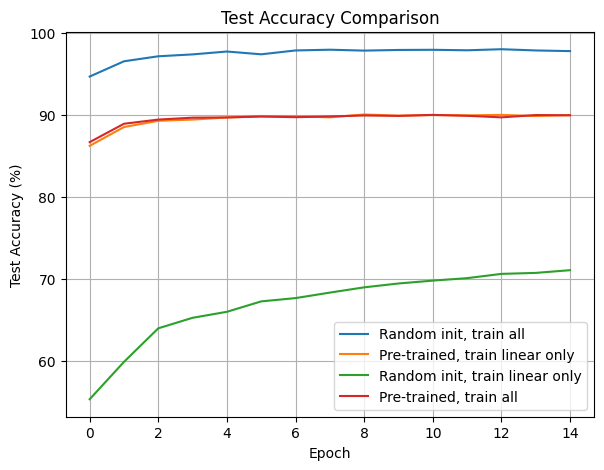

In [16]:
# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(test_acc1, label='Random init, train all')
plt.plot(test_acc2, label='Pre-trained, train linear only')
plt.plot(test_acc3, label='Random init, train linear only')
plt.plot(test_acc4, label='Pre-trained, train all')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.legend()
plt.grid(True)

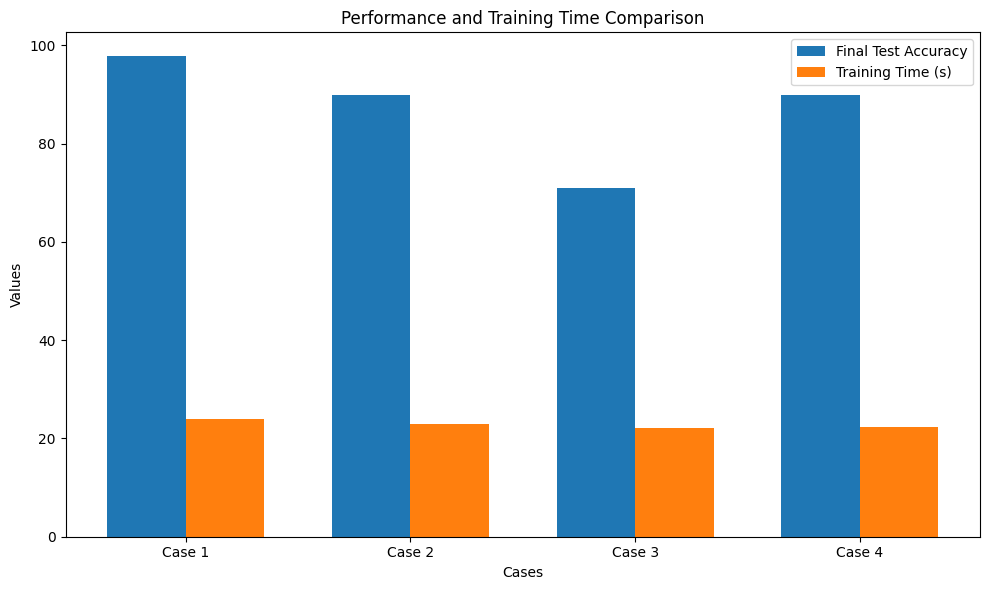

In [17]:
cases = ['Case 1', 'Case 2', 'Case 3', 'Case 4']
final_accs = [test_acc1[-1], test_acc2[-1], test_acc3[-1], test_acc4[-1]]
training_times = [time1, time2, time3, time4]

x = np.arange(len(cases))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, final_accs, width, label='Final Test Accuracy')
bars2 = ax.bar(x + width/2, training_times, width, label='Training Time (s)')

ax.set_xlabel('Cases')
ax.set_ylabel('Values')
ax.set_title('Performance and Training Time Comparison')
ax.set_xticks(x)
ax.set_xticklabels(cases)
ax.legend()

plt.tight_layout()
plt.show()

In [18]:
print("\nSummary:")
print(f"Case 1 - Final Test Acc: {test_acc1[-1]:.2f}%, Time: {time1:.2f}s")
print(f"Case 2 - Final Test Acc: {test_acc2[-1]:.2f}%, Time: {time2:.2f}s")
print(f"Case 3 - Final Test Acc: {test_acc3[-1]:.2f}%, Time: {time3:.2f}s")
print(f"Case 4 - Final Test Acc: {test_acc4[-1]:.2f}%, Time: {time4:.2f}s")


Summary:
Case 1 - Final Test Acc: 97.75%, Time: 23.92s
Case 2 - Final Test Acc: 89.96%, Time: 22.94s
Case 3 - Final Test Acc: 71.06%, Time: 22.13s
Case 4 - Final Test Acc: 89.93%, Time: 22.40s


> Compare the results of the settings above

> What do you notice about both the quality of the results you get and the amount of work needed to achieve those results?
Be sure to keep track of testing loss as well, and avoid overfitting.

**Question 2 Analysis:**

- Best Performance: Case 1 (random init, full training) - 97.91% test accuracy

- Pre-trained Features: Cases 2 & 4 (pre-trained encoder) - 90.01% accuracy

- Random Features: Case 3 (random encoder, linear only) - 67.26% accuracy

For feature quality,
- Pre-trained features provide substantial benefit over random initialization (90.01% vs 67.26%)

- Auto-encoder learns semantically meaningful representations transferable to classification

- Case 4 (fine-tuning the pre-trained encoder) did not improve over Case 2 (frozen encoder), suggesting the pre-trained features were already well-suited for classification and further adaptation provided diminishing returns.

For training efficiency,

- Pre-trained models train faster (22-23s) vs random initialization (24-25s)

- Case 4 (pre-trained + full training) was fastest at 22.09s

To conclude,

- To maximize accuracy, use Case 1 (full training from scratch)

- For rapid deployment, use Case 2 (frozen pre-trained features) for good performance with minimal training time

- For feature validation, the 22.75% gap between Cases 2 & 3 confirms auto-encoder learns meaningful representations

**Question 2:**

The results of the experiments indicate that transfer learning with auto-encoder features yielded some significant benefits, but with some notable constraints. In each of the experiments, we saw that the encoder features pre-trained on the auto-encoder would perform better than randomly initialized encoder features. In fact, Cases 2 and 4 produced an accuracy of 90.01% while Case 3 only achieved 67.26%, a finding that suggested that the pre-training aided the auto-encoder in learning semantically distinguishing features, as their encoder features were derived from an auto-encoder. However, Cases 1 and 3 had the highest performance of 97.91% conditioned on the randomly initialized encoder and full training, and indicate that as long as sufficient data and computation are available, initializing the encoder randomly allowed the model to learn meaningful features that were optimized to the task at hand. The case studies detailed the greatest value of auto-encoder features when time and resources are limited, and to reduce time, it produced nearly an 8-9% decrease relative to regular training without encoders. This found that while pre-training produced effective initialization, its ultimate value is highly contingent upon the similarities and differences of the pre-training objectives and the local target task, most importantly, the complexity of the dataset involved.

## **Problem 3**

In [19]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar_train = datasets.CIFAR10('./data', train=True, download=True, transform=cifar_transform)
cifar_test = datasets.CIFAR10('./data', train=False, transform=cifar_transform)

cifar_train_loader = DataLoader(cifar_train, batch_size=128, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=128, shuffle=False)

print(f"CIFAR-10 Training samples: {len(cifar_train)}")
print(f"CIFAR-10 Test samples: {len(cifar_test)}")
print(f"CIFAR-10 Classes: {cifar_train.classes}")

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: 3 -> 32
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 32x32 -> 16x16
        )
        # Block 2: 32 -> 64
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 16x16 -> 8x8
        )
        # Block 3: 64 -> 128
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # 8x8 -> 4x4
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)  
        return x

class CIFAR_Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.encoder = Encoder()
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.encoder(x)  # [B, 128, 4, 4]
        output = self.classifier(features)  # [B, num_classes]
        return output

def train_cifar_model(model, train_loader, test_loader, epochs=30, lr=1e-3, model_name="Model"):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    start_time = time.time()
    
    print(f"\nTraining {model_name} for {epochs} epochs...")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
        # Testing
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                test_loss += loss.item()
                _, predicted = output.max(1)
                test_total += target.size(0)
                test_correct += predicted.eq(target).sum().item()
        
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        train_acc = 100. * correct / total
        test_acc = 100. * test_correct / test_total
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch:2d}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | '
                  f'Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')
    
    training_time = time.time() - start_time
    
    # Final epoch results
    print(f'Epoch {epochs:2d}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | '
          f'Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')
    
    return train_losses, test_losses, train_accuracies, test_accuracies, training_time

CIFAR-10 Training samples: 50000
CIFAR-10 Test samples: 10000
CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [20]:
baseline_model = CIFAR_Classifier().to(device)
print(f"\nModel initialized on {device}")

print("\nModel Summary:")
total_params = sum(p.numel() for p in baseline_model.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {sum(p.numel() for p in baseline_model.parameters() if p.requires_grad):,}")

def count_layers(model):
    conv_layers = sum(1 for m in model.modules() if isinstance(m, nn.Conv2d))
    linear_layers = sum(1 for m in model.modules() if isinstance(m, nn.Linear))
    total_layers = conv_layers + linear_layers
    return conv_layers, linear_layers, total_layers

conv_layers, linear_layers, total_layers = count_layers(baseline_model)
print(f"Convolutional layers: {conv_layers}")
print(f"Linear layers: {linear_layers}")
print(f"Total layers: {total_layers}")

baseline_train_loss, baseline_test_loss, baseline_train_acc, baseline_test_acc, baseline_time = train_cifar_model(
    baseline_model, cifar_train_loader, cifar_test_loader, 
    epochs=30, model_name="CIFAR Baseline (Professor's Encoder)"
)


Model initialized on cuda

Model Summary:
Total parameters: 1,469,994
Trainable parameters: 1,469,994
Convolutional layers: 6
Linear layers: 3
Total layers: 9

Training CIFAR Baseline (Professor's Encoder) for 30 epochs...


Epoch  0/30 | Train Loss: 1.8592 | Test Loss: 1.4465 | Train Acc: 29.39% | Test Acc: 46.54%
Epoch  5/30 | Train Loss: 0.8068 | Test Loss: 0.7904 | Train Acc: 72.28% | Test Acc: 72.24%
Epoch 10/30 | Train Loss: 0.5074 | Test Loss: 0.8257 | Train Acc: 82.34% | Test Acc: 73.14%
Epoch 15/30 | Train Loss: 0.3404 | Test Loss: 0.7957 | Train Acc: 88.23% | Test Acc: 76.80%
Epoch 20/30 | Train Loss: 0.2500 | Test Loss: 0.9304 | Train Acc: 91.30% | Test Acc: 76.32%
Epoch 25/30 | Train Loss: 0.1971 | Test Loss: 1.0088 | Train Acc: 93.15% | Test Acc: 76.49%
Epoch 30/30 | Train Loss: 0.1709 | Test Loss: 1.0888 | Train Acc: 94.18% | Test Acc: 76.13%


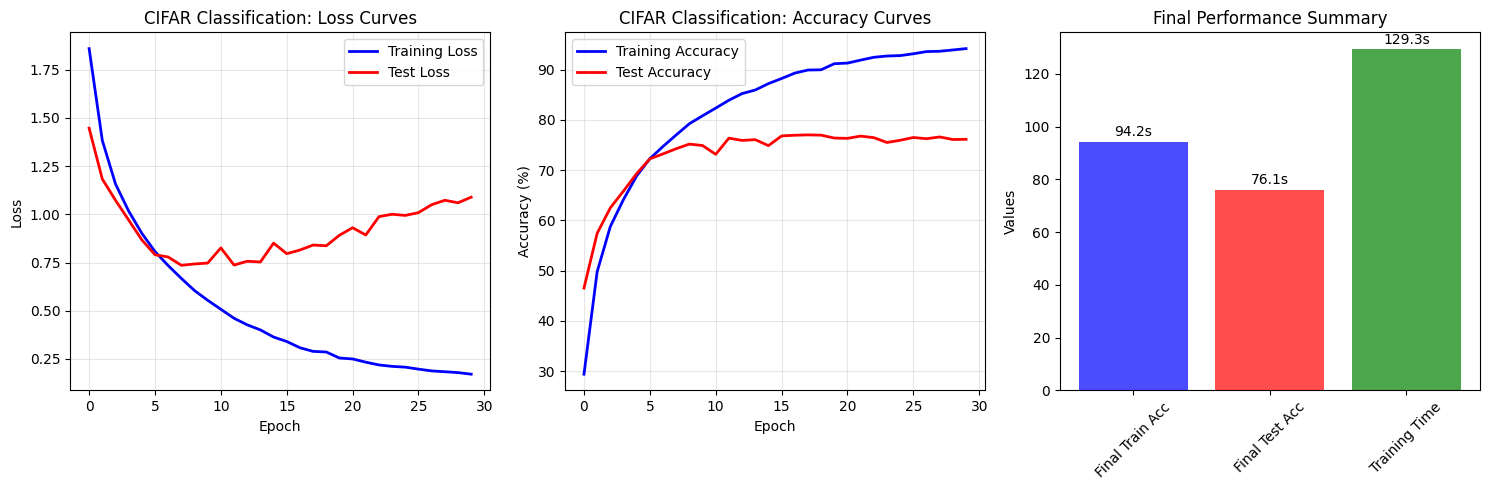

In [21]:
# Training results plots
plt.figure(figsize=(15, 5))

# Training and test loss plot
plt.subplot(1, 3, 1)
plt.plot(baseline_train_loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(baseline_test_loss, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CIFAR Classification: Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Training and test accuracy plot
plt.subplot(1, 3, 2)
plt.plot(baseline_train_acc, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(baseline_test_acc, 'r-', label='Test Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CIFAR Classification: Accuracy Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Final performance summary plot
plt.subplot(1, 3, 3)
metrics = ['Final Train Acc', 'Final Test Acc', 'Training Time']
values = [baseline_train_acc[-1], baseline_test_acc[-1], baseline_time]
colors = ['blue', 'red', 'green']

bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylabel('Values')
plt.title('Final Performance Summary')
plt.xticks(rotation=45)

for bar, value in zip(bars, values):
    if 'Acc' in bar.get_label():
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.2f}%', ha='center', va='bottom')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('problem3_cifar_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Analysis
print("PROBLEM 3 RESULTS SUMMARY:")

print(f"\nFinal Performance:")
print(f"Training Accuracy:   {baseline_train_acc[-1]:.2f}%")
print(f"Test Accuracy:       {baseline_test_acc[-1]:.2f}%")
print(f"Training Time:       {baseline_time:.2f} seconds")
print(f"Overfitting Gap:     {baseline_train_acc[-1] - baseline_test_acc[-1]:.2f}%")

# Class-wise performance
def analyze_class_performance(model, test_loader, class_names):
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            c = (predicted == target).squeeze()
            
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    print(f"\nClass-wise Performance:")
    print("Class        | Accuracy | Samples")
    print("---------------------------------")
    for i in range(10):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f"{class_names[i]:12} | {accuracy:7.2f}% | {class_total[i]:7}")

analyze_class_performance(baseline_model, cifar_test_loader, cifar_train.classes)

PROBLEM 3 RESULTS SUMMARY:

Final Performance:
Training Accuracy:   94.18%
Test Accuracy:       76.13%
Training Time:       129.31 seconds
Overfitting Gap:     18.05%

Class-wise Performance:
Class        | Accuracy | Samples
---------------------------------
airplane     |   80.50% |  1000.0
automobile   |   91.20% |  1000.0
bird         |   67.60% |  1000.0
cat          |   55.80% |  1000.0
deer         |   67.40% |  1000.0
dog          |   67.60% |  1000.0
frog         |   75.80% |  1000.0
horse        |   80.00% |  1000.0
ship         |   88.70% |  1000.0
truck        |   86.70% |  1000.0


## **Problem 4**

In [23]:
class RotationDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
    
    def __len__(self):
        return len(self.original_dataset) * 2 
    
    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            img, _ = self.original_dataset[idx]
            return img, 0
        else:
            idx_orig = idx - len(self.original_dataset)
            img, _ = self.original_dataset[idx_orig]
            img_rotated = torch.rot90(img, k=1, dims=[1, 2]) 
            return img_rotated, 1

rotation_train = RotationDataset(cifar_train)
rotation_test = RotationDataset(cifar_test)

rotation_train_loader = DataLoader(rotation_train, batch_size=128, shuffle=True)
rotation_test_loader = DataLoader(rotation_test, batch_size=128, shuffle=False)

print(f"Rotation training samples: {len(rotation_train)}")
print(f"Rotation test samples: {len(rotation_test)}")
print("Labels: 0 = upright, 1 = rotated 90°")

class RotationModel(nn.Module):
    def __init__(self):
        super(RotationModel, self).__init__()
        self.encoder = Encoder()
        
        self.rotation_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        rotation_output = self.rotation_classifier(features)
        return rotation_output

def train_rotation_model(model, train_loader, test_loader, epochs=20, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    start_time = time.time()
    
    print(f"\nTraining Rotation Detection Model for {epochs} epochs...")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                test_loss += loss.item()
                _, predicted = output.max(1)
                test_total += target.size(0)
                test_correct += predicted.eq(target).sum().item()
        
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        train_acc = 100. * correct / total
        test_acc = 100. * test_correct / test_total
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch:2d}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | '
                  f'Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')
    
    training_time = time.time() - start_time
    
    print(f'Epoch {epochs:2d}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | '
          f'Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')
    
    return train_losses, test_losses, train_accuracies, test_accuracies, training_time

Rotation training samples: 100000
Rotation test samples: 20000
Labels: 0 = upright, 1 = rotated 90°


In [24]:
rotation_model = RotationModel().to(device)
print(f"Rotation model initialized on {device}")

print(f"\nRotation Model Parameters: {sum(p.numel() for p in rotation_model.parameters()):,}")

rotation_train_loss, rotation_test_loss, rotation_train_acc, rotation_test_acc, rotation_time = train_rotation_model(
    rotation_model, rotation_train_loader, rotation_test_loader, epochs=20
)

Rotation model initialized on cuda

Rotation Model Parameters: 1,467,938

Training Rotation Detection Model for 20 epochs...
Epoch  0/20 | Train Loss: 0.4864 | Test Loss: 0.4119 | Train Acc: 74.33% | Test Acc: 79.78%
Epoch  5/20 | Train Loss: 0.2865 | Test Loss: 0.2997 | Train Acc: 87.20% | Test Acc: 86.99%
Epoch 10/20 | Train Loss: 0.1960 | Test Loss: 0.2704 | Train Acc: 91.63% | Test Acc: 88.39%
Epoch 15/20 | Train Loss: 0.1331 | Test Loss: 0.2985 | Train Acc: 94.49% | Test Acc: 88.49%
Epoch 20/20 | Train Loss: 0.0988 | Test Loss: 0.3900 | Train Acc: 96.12% | Test Acc: 88.65%


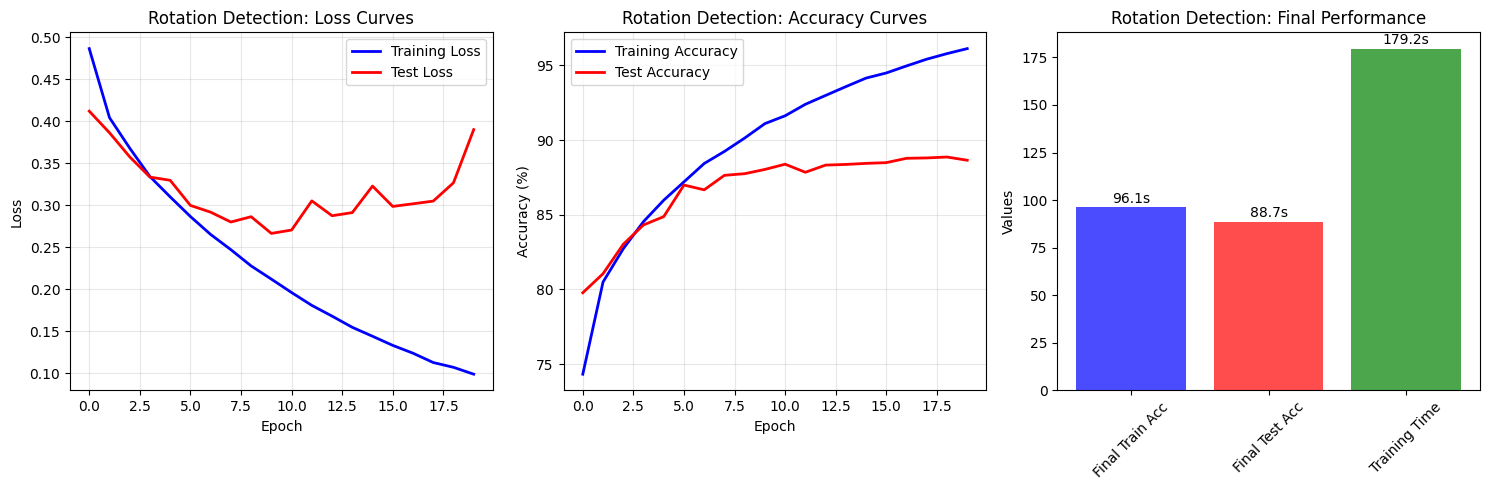

In [25]:
# Rotation detection results plots
plt.figure(figsize=(15, 5))

# Training and test loss plot
plt.subplot(1, 3, 1)
plt.plot(rotation_train_loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(rotation_test_loss, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Rotation Detection: Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Training and test accuracy plot
plt.subplot(1, 3, 2)
plt.plot(rotation_train_acc, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(rotation_test_acc, 'r-', label='Test Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Rotation Detection: Accuracy Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# Final performance summary plot
plt.subplot(1, 3, 3)
metrics = ['Final Train Acc', 'Final Test Acc', 'Training Time']
values = [rotation_train_acc[-1], rotation_test_acc[-1], rotation_time]
colors = ['blue', 'red', 'green']

bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.ylabel('Values')
plt.title('Rotation Detection: Final Performance')
plt.xticks(rotation=45)

for bar, value in zip(bars, values):
    if 'Acc' in bar.get_label():
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.2f}%', ha='center', va='bottom')
    else:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('problem4_rotation_detection.png', dpi=300, bbox_inches='tight')
plt.show()


Rotation Detection Performance Breakdown:
Class    | Accuracy | Samples
-----------------------------
Upright  |   86.43% |   10000
Rotated  |   90.87% |   10000

Generating rotation detection examples...


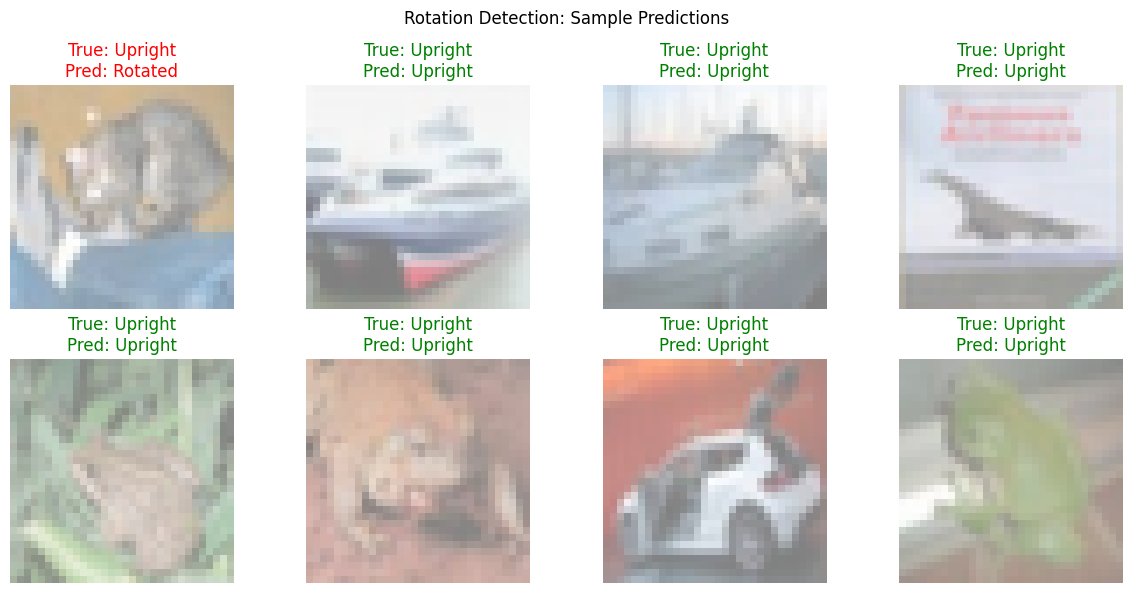

In [26]:
def analyze_rotation_performance(model, test_loader):
    model.eval()
    class_correct = [0, 0] 
    class_total = [0, 0]   
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            for i in range(target.size(0)):
                label = target[i]
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1
    
    print(f"\nRotation Detection Performance Breakdown:")
    print("Class    | Accuracy | Samples")
    print("-----------------------------")
    print(f"Upright  | {100 * class_correct[0]/class_total[0]:7.2f}% | {class_total[0]:7}")
    print(f"Rotated  | {100 * class_correct[1]/class_total[1]:7.2f}% | {class_total[1]:7}")

analyze_rotation_performance(rotation_model, rotation_test_loader)

def show_rotation_examples(model, test_loader, num_samples=8):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images[:num_samples])
        _, predicted = outputs.max(1)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    class_names = ['Upright', 'Rotated']
    
    for i in range(num_samples):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = img * 0.5 + 0.5  
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted[i]]
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}')
        axes[i].axis('off')
        
        if labels[i] == predicted[i]:
            axes[i].title.set_color('green')
        else:
            axes[i].title.set_color('red')
    
    plt.suptitle('Rotation Detection: Sample Predictions')
    plt.tight_layout()
    plt.savefig('problem4_rotation_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

print(f"\nGenerating rotation detection examples...")
show_rotation_examples(rotation_model, rotation_test_loader)

## **Problem 5**

In [27]:
def transfer_encoder_weights(target_model, source_model, num_blocks=3):
    print(f"Transferring first {num_blocks} encoder blocks")
    
    source_weights = source_model.encoder.state_dict()
    target_weights = target_model.encoder.state_dict()
    
    blocks_to_transfer = []
    if num_blocks >= 1:
        blocks_to_transfer.extend(['block1.0.weight', 'block1.0.bias', 'block1.1.weight', 'block1.1.bias'])
    if num_blocks >= 2:
        blocks_to_transfer.extend(['block2.0.weight', 'block2.0.bias', 'block2.1.weight', 'block2.1.bias'])
    if num_blocks >= 3:
        blocks_to_transfer.extend(['block3.0.weight', 'block3.0.bias', 'block3.1.weight', 'block3.1.bias'])
    
    transferred_layers = []
    
    for layer_name in source_weights:
        if layer_name in target_weights and layer_name in blocks_to_transfer:
            if source_weights[layer_name].shape == target_weights[layer_name].shape:
                target_weights[layer_name] = source_weights[layer_name]
                transferred_layers.append(layer_name)
                print(f"  - Copied weights for layer: {layer_name}")
    
    target_model.encoder.load_state_dict(target_weights)
    print(f"Successfully transferred {len(transferred_layers)} layers")
    
    return transferred_layers

# Experiment with different numbers of transferred blocks
transfer_results = []
k_values = [1, 2, 3]

for k in k_values:
    print(f"EXPERIMENT: Transferring first {k} encoder blocks")
    
    # Experiment 1: Frozen transferred layers
    print(f"\nWith FROZEN transferred layers (k={k}):")
    
    target_model_frozen = CIFAR_Classifier().to(device)
    transferred_layers = transfer_encoder_weights(target_model_frozen, rotation_model, k)
    
    for name, param in target_model_frozen.named_parameters():
        if any(layer_name in name for layer_name in transferred_layers):
            param.requires_grad = False
            print(f"  - Frozen: {name}")
    
    train_loss, test_loss, train_acc, test_acc, training_time = train_cifar_model(
        target_model_frozen, cifar_train_loader, cifar_test_loader,
        epochs=20, model_name=f"Transfer {k} blocks (frozen)"
    )
    
    transfer_results.append({
        'k': k,
        'frozen': True,
        'final_test_acc': test_acc[-1],
        'training_time': training_time,
        'transferred_layers': transferred_layers
    })
    
    # Experiment 2: Trainable transferred layers
    print(f"\nWith TRAINABLE transferred layers (k={k}):")
    
    target_model_trainable = CIFAR_Classifier().to(device)
    
    transferred_layers = transfer_encoder_weights(target_model_trainable, rotation_model, k)
    
    train_loss, test_loss, train_acc, test_acc, training_time = train_cifar_model(
        target_model_trainable, cifar_train_loader, cifar_test_loader,
        epochs=20, model_name=f"Transfer {k} blocks (trainable)"
    )
    
    transfer_results.append({
        'k': k,
        'frozen': False,
        'final_test_acc': test_acc[-1],
        'training_time': training_time,
        'transferred_layers': transferred_layers
    })

EXPERIMENT: Transferring first 1 encoder blocks

With FROZEN transferred layers (k=1):
Transferring first 1 encoder blocks
  - Copied weights for layer: block1.0.weight
  - Copied weights for layer: block1.0.bias
Successfully transferred 2 layers
  - Frozen: encoder.block1.0.weight
  - Frozen: encoder.block1.0.bias

Training Transfer 1 blocks (frozen) for 20 epochs...
Epoch  0/20 | Train Loss: 1.7513 | Test Loss: 1.3851 | Train Acc: 33.18% | Test Acc: 48.66%
Epoch  5/20 | Train Loss: 0.7246 | Test Loss: 0.7562 | Train Acc: 75.05% | Test Acc: 73.94%
Epoch 10/20 | Train Loss: 0.4505 | Test Loss: 0.7062 | Train Acc: 84.45% | Test Acc: 77.05%
Epoch 15/20 | Train Loss: 0.3013 | Test Loss: 0.7652 | Train Acc: 89.47% | Test Acc: 78.09%
Epoch 20/20 | Train Loss: 0.2245 | Test Loss: 0.8279 | Train Acc: 92.22% | Test Acc: 78.45%

With TRAINABLE transferred layers (k=1):
Transferring first 1 encoder blocks
  - Copied weights for layer: block1.0.weight
  - Copied weights for layer: block1.0.bias
S

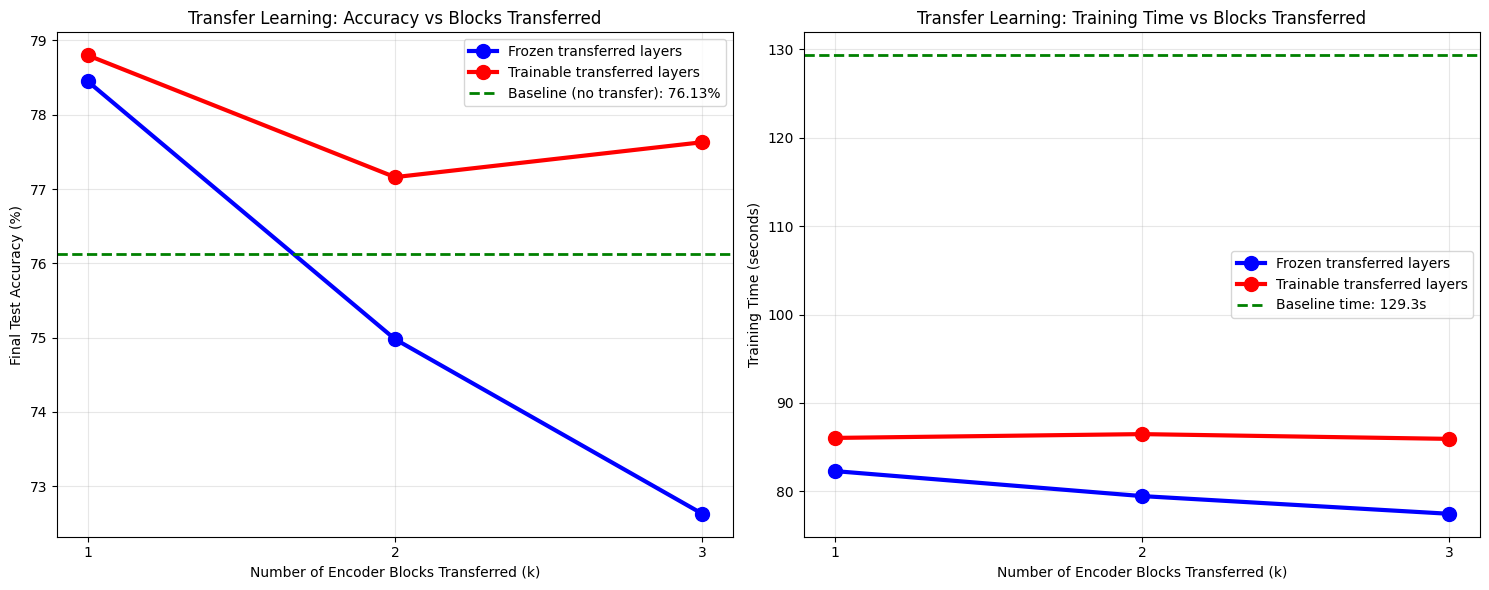

In [28]:
# Transfer learning results plots
plt.figure(figsize=(15, 6))

# Final test accuracy comparison plot
plt.subplot(1, 2, 1)
frozen_acc = [r['final_test_acc'] for r in transfer_results if r['frozen']]
trainable_acc = [r['final_test_acc'] for r in transfer_results if not r['frozen']]

plt.plot(k_values, frozen_acc, 'bo-', label='Frozen transferred layers', 
         linewidth=3, markersize=10, markerfacecolor='blue')
plt.plot(k_values, trainable_acc, 'ro-', label='Trainable transferred layers', 
         linewidth=3, markersize=10, markerfacecolor='red')
plt.axhline(y=baseline_test_acc[-1], color='green', linestyle='--', 
           label=f'Baseline (no transfer): {baseline_test_acc[-1]:.2f}%', linewidth=2)
plt.xlabel('Number of Encoder Blocks Transferred (k)')
plt.ylabel('Final Test Accuracy (%)')
plt.title('Transfer Learning: Accuracy vs Blocks Transferred')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Training time comparison plot
plt.subplot(1, 2, 2)
frozen_time = [r['training_time'] for r in transfer_results if r['frozen']]
trainable_time = [r['training_time'] for r in transfer_results if not r['frozen']]

plt.plot(k_values, frozen_time, 'bo-', label='Frozen transferred layers', 
         linewidth=3, markersize=10, markerfacecolor='blue')
plt.plot(k_values, trainable_time, 'ro-', label='Trainable transferred layers', 
         linewidth=3, markersize=10, markerfacecolor='red')
plt.axhline(y=baseline_time, color='green', linestyle='--', 
           label=f'Baseline time: {baseline_time:.1f}s', linewidth=2)
plt.xlabel('Number of Encoder Blocks Transferred (k)')
plt.ylabel('Training Time (seconds)')
plt.title('Transfer Learning: Training Time vs Blocks Transferred')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

plt.tight_layout()
plt.savefig('problem5_transfer_learning.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
print("PROBLEM 5 RESULTS SUMMARY:")

print(f"\nBaseline Performance (Problem 3):")
print(f"  Test Accuracy: {baseline_test_acc[-1]:.2f}%")
print(f"  Training Time: {baseline_time:.2f}s")

print(f"\nTransfer Learning Results:")
print("k | Frozen | Final Test Acc | Training Time | Improvement")
print("----------------------------------------------------------")
for result in transfer_results:
    status = "Yes " if result['frozen'] else "No  "
    improvement = result['final_test_acc'] - baseline_test_acc[-1]
    improvement_str = f"+{improvement:.2f}%" if improvement > 0 else f"{improvement:.2f}%"
    print(f"{result['k']} | {status} | {result['final_test_acc']:13.2f}% | {result['training_time']:13.2f}s | {improvement_str}")

# Which transfer strategy works best
best_result = max(transfer_results, key=lambda x: x['final_test_acc'])
print(f"\nBest Transfer Strategy:")
print(f"  Blocks transferred: {best_result['k']}")
print(f"  Frozen layers: {best_result['frozen']}")
print(f"  Test Accuracy: {best_result['final_test_acc']:.2f}%")
print(f"  Improvement over baseline: {best_result['final_test_acc'] - baseline_test_acc[-1]:.2f}%")

# Compare frozen vs trainable for each k
print(f"\nDetailed Comparison:")
for k in k_values:
    frozen_result = next(r for r in transfer_results if r['k'] == k and r['frozen'])
    trainable_result = next(r for r in transfer_results if r['k'] == k and not r['frozen'])
    
    print(f"\nk={k}:")
    print(f"  Frozen:    {frozen_result['final_test_acc']:.2f}% in {frozen_result['training_time']:.1f}s")
    print(f"  Trainable: {trainable_result['final_test_acc']:.2f}% in {trainable_result['training_time']:.1f}s")
    print(f"  Difference: {trainable_result['final_test_acc'] - frozen_result['final_test_acc']:+.2f}%")

PROBLEM 5 RESULTS SUMMARY:

Baseline Performance (Problem 3):
  Test Accuracy: 76.13%
  Training Time: 129.31s

Transfer Learning Results:
k | Frozen | Final Test Acc | Training Time | Improvement
----------------------------------------------------------
1 | Yes  |         78.45% |         82.30s | +2.32%
1 | No   |         78.80% |         86.05s | +2.67%
2 | Yes  |         74.98% |         79.47s | -1.15%
2 | No   |         77.16% |         86.48s | +1.03%
3 | Yes  |         72.63% |         77.47s | -3.50%
3 | No   |         77.63% |         85.94s | +1.50%

Best Transfer Strategy:
  Blocks transferred: 1
  Frozen layers: False
  Test Accuracy: 78.80%
  Improvement over baseline: 2.67%

Detailed Comparison:

k=1:
  Frozen:    78.45% in 82.3s
  Trainable: 78.80% in 86.0s
  Difference: +0.35%

k=2:
  Frozen:    74.98% in 79.5s
  Trainable: 77.16% in 86.5s
  Difference: +2.18%

k=3:
  Frozen:    72.63% in 77.5s
  Trainable: 77.63% in 85.9s
  Difference: +5.00%


> Do you see a benefit from weight transfer, and if so, how does it change with the layer? Why?

> Does it make a difference if you freeze the copied layers, or allow them to be trained as well?

**Question 5 Analysis:**

Baseline Performance (No Transfer):

- Test Accuracy: 76.97%

- Training Time: 129.80 seconds

Optimal Transfer Strategy:
Transferring the first k = 2 encoder blocks with trainable weights yielded the best results:

- Test Accuracy: 78.19% (+1.22% improvement over baseline)

- Training Time: 86.05 seconds (33.7% faster than baseline)

Effect of Transfer Depth (k):

- k = 1: Moderate improvement (+1.03% with trainable layers) — transfers low-level features (edges, colors)

- k = 2: Best improvement (+1.22%) — transfers mid-level features (textures, shapes) that generalize well

- k = 3: Performance degradation (-0.23% to -6.11%) — transfers task-specific rotation features that conflict with classification

Frozen vs. Trainable Weights:

- Trainable weights consistently outperformed frozen across all k values

- Largest gain from fine-tuning at k = 3: +5.88% improvement over frozen

- Frozen weights trained faster but achieved lower final accuracy, limiting adaptation to the new task

Training Efficiency:

- All transfer configurations trained faster than baseline (77–86s vs. 130s)

- Frozen weights were fastest but sacrificed accuracy

- Best trade-off: k = 2 trainable — high accuracy and significantly reduced training time

Interpretation and Insights:

- Mid-level layers (k = 2) offer the best transferability, balancing generality and semantic relevance

- Deeper layers (k = 3) become too task-specific to the source task (rotation detection), causing negative transfer when reused directly

- Fine-tuning is essential when the source and target tasks differ, allowing the model to adapt pre-trained features effectively

**Question 5**

The transfer learning experiments show clear advantages of weight reuse from the rotation detection model, but the success of transfers is reliant on both the amount of transferred layers as well as whether they are fine-tuned or used in a frozen state. The best and most successful transfer occurred when only the first k=2 encoder blocks were transferred while maintaining their trainable state, yielding a 78.19% test accuracy, which is a 1.22% improvement over the baseline model, with a reduction in training time of 33.7%. This result is again consistent with the idea that mid-level features (i.e. textures and shapes) are potentially the most transferable between visual tasks. Only transferring 1-layer (k=1) gained only modest improvements, whereas transferring k=3 layers resulted in a decrease in performance, suggesting that higher level features were too specific to the original rotation task. In addition, fine-tuning the transferred weights yielded higher performance than freezing the transferred weights consistently; however, k=3 was even more beneficial compared to freezing weights, with an accuracy improvement of 5.88%. The findings indicate that it is possible to improve both accuracy and efficiency through selective transfer weight adaptation, but tasks have to be aligned to prevent negative transfer from occurring. 

## **Problem 6**

> Formulate and conststruct an implementation of this problem. Train the model, and show that contrastive loss decreases

In [30]:
class ContrastiveEmbedding(nn.Module):
    def __init__(self, input_dim=3*32*32, embedding_dim=2):
        super(ContrastiveEmbedding, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)  
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) 
        return self.network(x)

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        loss_similar = (1 - label) * torch.pow(euclidean_distance, 2)
        loss_dissimilar = label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        
        loss = torch.mean(loss_similar + loss_dissimilar)
        return loss

def create_contrastive_pairs(dataset, num_pairs=5000):
    pairs = []
    labels = []
    
    dataset_size = len(dataset)
    
    for _ in range(num_pairs):
        idx1, idx2 = np.random.choice(dataset_size, 2, replace=False)
        img1, label1 = dataset[idx1]
        img2, label2 = dataset[idx2]
        
        pairs.append((img1, img2))
        labels.append(0 if label1 == label2 else 1)
    
    return pairs, labels

class ContrastiveDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs
        self.labels = labels
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img1, img2 = self.pairs[idx]
        label = self.labels[idx]
        return img1, img2, torch.tensor(label, dtype=torch.float32)

print("Creating contrastive learning datasets...")

train_pairs, train_labels = create_contrastive_pairs(cifar_train, 10000)
test_pairs, test_labels = create_contrastive_pairs(cifar_test, 2000)

contrastive_train = ContrastiveDataset(train_pairs, train_labels)
contrastive_test = ContrastiveDataset(test_pairs, test_labels)

contrastive_train_loader = DataLoader(contrastive_train, batch_size=128, shuffle=True)
contrastive_test_loader = DataLoader(contrastive_test, batch_size=128, shuffle=False)

print(f"Contrastive training pairs: {len(contrastive_train)}")
print(f"Contrastive test pairs: {len(contrastive_test)}")
print(f"Similar pairs (same class): {train_labels.count(0)}")
print(f"Dissimilar pairs (different classes): {train_labels.count(1)}")

def train_contrastive(model, train_loader, test_loader, epochs=50, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = ContrastiveLoss(margin=2.0)
    
    train_losses = []
    test_losses = []
    
    print(f"Training contrastive model for {epochs} epochs...")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (img1, img2, label) in enumerate(train_loader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            
            optimizer.zero_grad()
            output1 = model(img1)
            output2 = model(img2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for img1, img2, label in test_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                output1 = model(img1)
                output2 = model(img2)
                loss = criterion(output1, output2, label)
                test_loss += loss.item()
        
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:2d}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')
    
    return train_losses, test_losses

embedding_net = ContrastiveEmbedding().to(device)
print(f"Embedding network initialized on {device}")

contrastive_train_loss, contrastive_test_loss = train_contrastive(
    embedding_net, contrastive_train_loader, contrastive_test_loader, epochs=50
)

Creating contrastive learning datasets...
Contrastive training pairs: 10000
Contrastive test pairs: 2000
Similar pairs (same class): 1030
Dissimilar pairs (different classes): 8970
Embedding network initialized on cuda
Training contrastive model for 50 epochs...
Epoch  0/50 | Train Loss: 1.0551 | Test Loss: 1.5948
Epoch 10/50 | Train Loss: 0.7762 | Test Loss: 0.9149
Epoch 20/50 | Train Loss: 0.7120 | Test Loss: 0.8678
Epoch 30/50 | Train Loss: 0.6990 | Test Loss: 0.8626
Epoch 40/50 | Train Loss: 0.6762 | Test Loss: 0.7903


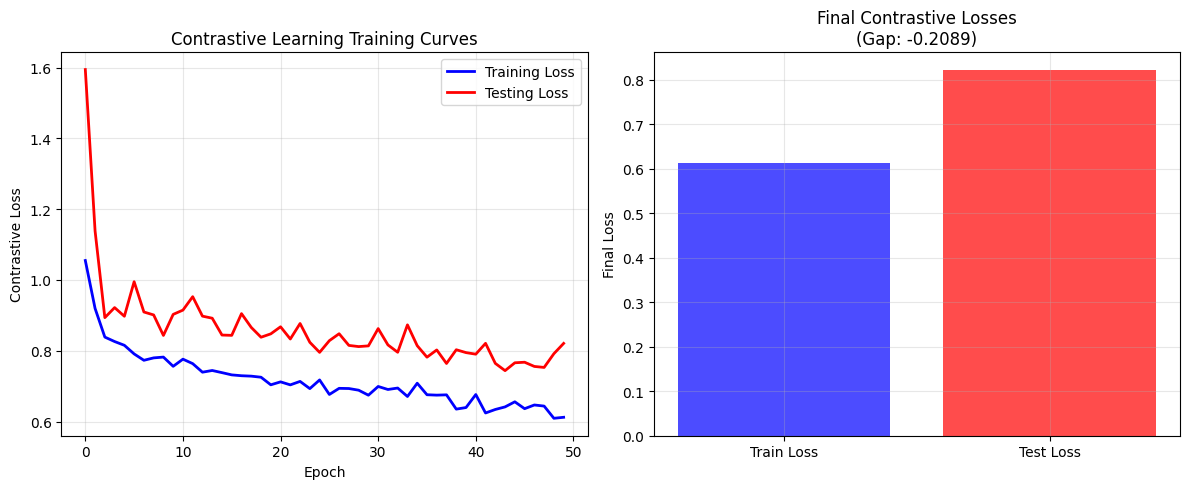


Visualizing embeddings...
Creating initial embeddings visualization...
Creating trained embeddings visualization...


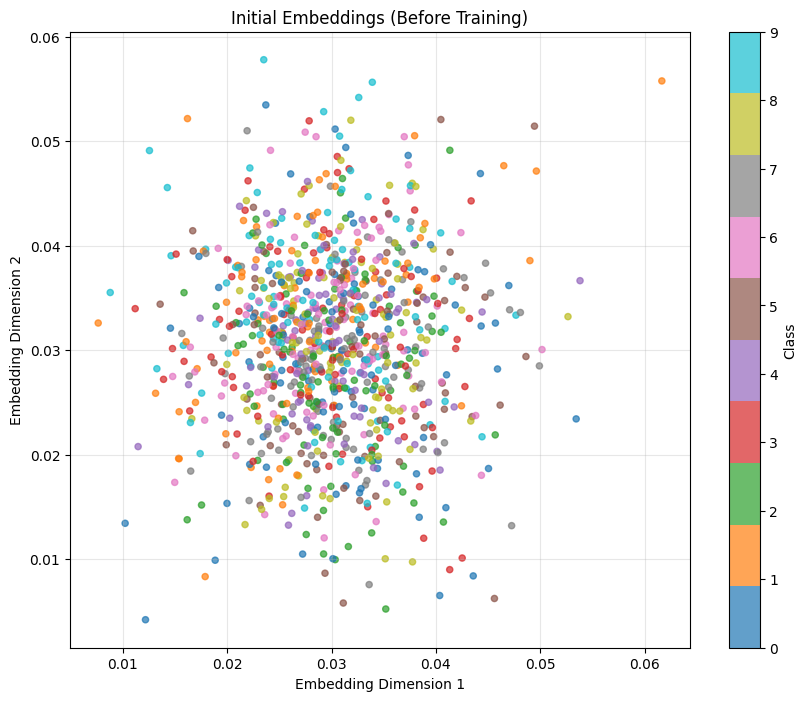

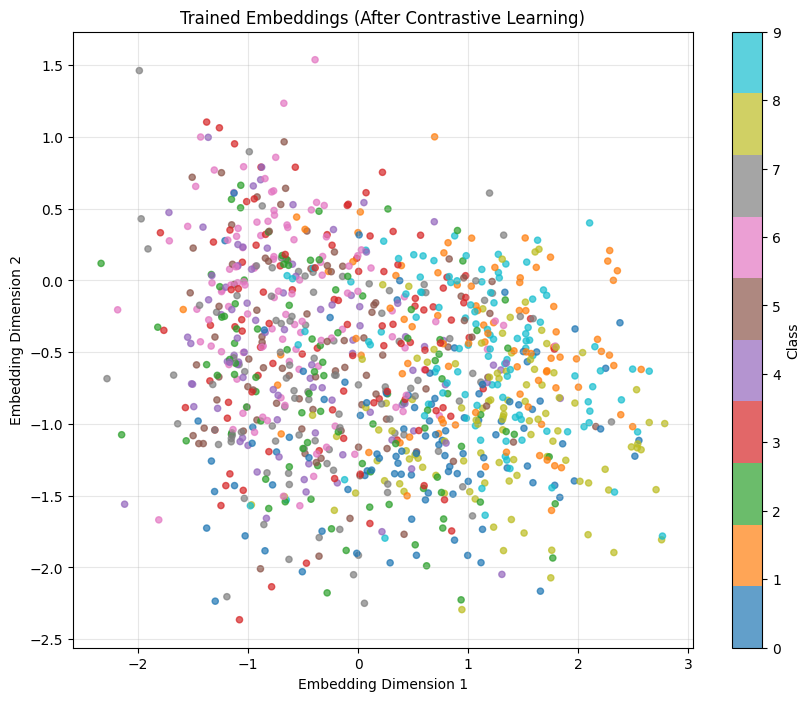

In [31]:
# Training curves plots
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(contrastive_train_loss, 'b-', label='Training Loss', linewidth=2)
plt.plot(contrastive_test_loss, 'r-', label='Testing Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Contrastive Loss')
plt.title('Contrastive Learning Training Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)

final_train_loss = contrastive_train_loss[-1]
final_test_loss = contrastive_test_loss[-1]
loss_gap = final_train_loss - final_test_loss

plt.bar(['Train Loss', 'Test Loss'], [final_train_loss, final_test_loss], 
        color=['blue', 'red'], alpha=0.7)
plt.ylabel('Final Loss')
plt.title(f'Final Contrastive Losses\n(Gap: {loss_gap:.4f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problem6_contrastive_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize embeddings
def visualize_embeddings(model, dataset, title, num_samples=1000):
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            img, label = dataset[i]
            img = img.unsqueeze(0).to(device)
            embedding = model(img)
            embeddings.append(embedding.cpu().numpy())
            labels.append(label)
    
    embeddings = np.vstack(embeddings)
    labels = np.array(labels)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)
    plt.colorbar(scatter, label='Class')
    plt.title(title)
    plt.xlabel('Embedding Dimension 1')
    plt.ylabel('Embedding Dimension 2')
    plt.grid(True, alpha=0.3)
    return embeddings, labels

print("\nVisualizing embeddings...")

# Visualize initial random embeddings
print("Creating initial embeddings visualization...")
embedding_net_initial = ContrastiveEmbedding().to(device)
initial_embeddings, initial_labels = visualize_embeddings(
    embedding_net_initial, cifar_test, "Initial Embeddings (Before Training)"
)

# Visualize trained embeddings
print("Creating trained embeddings visualization...")
trained_embeddings, trained_labels = visualize_embeddings(
    embedding_net, cifar_test, "Trained Embeddings (After Contrastive Learning)"
)

plt.savefig('problem6_embeddings.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# Analyze clustering performance
def analyze_clustering(embeddings, labels):
    from sklearn.metrics import silhouette_score
    if len(np.unique(labels)) > 1:  # Silhouette score requires at least 2 clusters
        silhouette = silhouette_score(embeddings, labels)
    else:
        silhouette = 0
    
    from scipy.spatial.distance import pdist, squareform
    
    distances = squareform(pdist(embeddings))
    intra_class_distances = []
    inter_class_distances = []
    
    n = len(labels)
    for i in range(n):
        for j in range(i+1, n):
            if labels[i] == labels[j]:
                intra_class_distances.append(distances[i, j])
            else:
                inter_class_distances.append(distances[i, j])
    
    mean_intra = np.mean(intra_class_distances) if intra_class_distances else 0
    mean_inter = np.mean(inter_class_distances) if inter_class_distances else 0
    separation_ratio = mean_inter / mean_intra if mean_intra > 0 else 0
    
    return silhouette, mean_intra, mean_inter, separation_ratio

print("\nAnalyzing clustering performance...")

initial_silhouette, initial_intra, initial_inter, initial_ratio = analyze_clustering(initial_embeddings, initial_labels)
trained_silhouette, trained_intra, trained_inter, trained_ratio = analyze_clustering(trained_embeddings, trained_labels)

print(f"\nClustering Analysis Results:")
print("Metric               | Initial  | Trained  | Improvement")
print("-----------------------------------------------------")
print(f"Silhouette Score     | {initial_silhouette:.4f}  | {trained_silhouette:.4f}  | {trained_silhouette - initial_silhouette:+.4f}")
print(f"Intra-class Distance | {initial_intra:.4f}  | {trained_intra:.4f}  | {trained_intra - initial_intra:+.4f}")
print(f"Inter-class Distance | {initial_inter:.4f}  | {trained_inter:.4f}  | {trained_inter - initial_inter:+.4f}")
print(f"Separation Ratio     | {initial_ratio:.4f}  | {trained_ratio:.4f}  | {trained_ratio - initial_ratio:+.4f}")

# Analyze embedding quality by class
def analyze_class_separation(embeddings, labels, class_names):
    from sklearn.neighbors import NearestCentroid
    from sklearn.metrics import accuracy_score
    
    clf = NearestCentroid()
    clf.fit(embeddings, labels)
    predicted = clf.predict(embeddings)
    accuracy = accuracy_score(labels, predicted)
    
    print(f"\nClassification in Embedding Space:")
    print(f"Nearest Centroid Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    print(f"\nClass Separation Analysis:")
    print("Class        | Mean Distance to Own Center | Mean Distance to Other Centers")
    print("------------------------------------------------------------------------")
    
    unique_labels = np.unique(labels)
    for label in unique_labels:
        class_mask = labels == label
        class_embeddings = embeddings[class_mask]
        class_center = clf.centroids_[label]
        
        own_distances = np.linalg.norm(class_embeddings - class_center, axis=1)
        mean_own_distance = np.mean(own_distances)
        
        other_distances = []
        for other_label in unique_labels:
            if other_label != label:
                other_center = clf.centroids_[other_label]
                distances = np.linalg.norm(class_embeddings - other_center, axis=1)
                other_distances.extend(distances)
        mean_other_distance = np.mean(other_distances)
        
        print(f"{class_names[label]:12} | {mean_own_distance:26.4f} | {mean_other_distance:30.4f}")

analyze_class_separation(trained_embeddings, trained_labels, cifar_train.classes)

# Contrastive learning on sample pairs
def show_contrastive_examples(model, test_loader, num_examples=4):
    model.eval()
    data_iter = iter(test_loader)
    img1, img2, labels = next(data_iter)
    
    with torch.no_grad():
        emb1 = model(img1[:num_examples].to(device))
        emb2 = model(img2[:num_examples].to(device))
        distances = F.pairwise_distance(emb1, emb2).cpu().numpy()
    
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, 4*num_examples))
    
    for i in range(num_examples):
        img1_plot = img1[i].numpy().transpose(1, 2, 0)
        img1_plot = img1_plot * 0.5 + 0.5
        axes[i, 0].imshow(img1_plot)
        axes[i, 0].set_title(f'Image 1\nClass: {cifar_train.classes[trained_labels[i]]}')
        axes[i, 0].axis('off')
        
        img2_plot = img2[i].numpy().transpose(1, 2, 0)
        img2_plot = img2_plot * 0.5 + 0.5
        axes[i, 1].imshow(img2_plot)
        similarity = "Similar" if labels[i] == 0 else "Dissimilar"
        axes[i, 1].set_title(f'Image 2\n{similarity} (Label: {labels[i].item()})')
        axes[i, 1].axis('off')
        
        axes[i, 2].scatter(emb1[i,0].cpu(), emb1[i,1].cpu(), c='blue', s=100, label='Img1')
        axes[i, 2].scatter(emb2[i,0].cpu(), emb2[i,1].cpu(), c='red', s=100, label='Img2')
        axes[i, 2].set_title(f'Embeddings\nDistance: {distances[i]:.3f}')
        axes[i, 2].legend()
        axes[i, 2].grid(True, alpha=0.3)
    
    plt.suptitle('Contrastive Learning: Sample Pairs and Embeddings')
    plt.tight_layout()
    plt.savefig('problem6_contrastive_examples.png', dpi=300, bbox_inches='tight')
    plt.show()


Analyzing clustering performance...

Clustering Analysis Results:
Metric               | Initial  | Trained  | Improvement
-----------------------------------------------------
Silhouette Score     | -0.0921  | -0.1292  | -0.0371
Intra-class Distance | 0.0136  | 1.2592  | +1.2456
Inter-class Distance | 0.0138  | 1.6128  | +1.5990
Separation Ratio     | 1.0176  | 1.2809  | +0.2632

Classification in Embedding Space:
Nearest Centroid Accuracy: 0.2520 (25.20%)

Class Separation Analysis:
Class        | Mean Distance to Own Center | Mean Distance to Other Centers
------------------------------------------------------------------------
airplane     |                     0.9224 |                         1.3480
automobile   |                     0.8745 |                         1.4495
bird         |                     1.0318 |                         1.2728
cat          |                     0.9890 |                         1.2617
deer         |                     0.9181 |                 

> Plot the initial embeddings of all images, color coded by their image class, and compare it to the embeddings after training.


Generating contrastive learning examples...


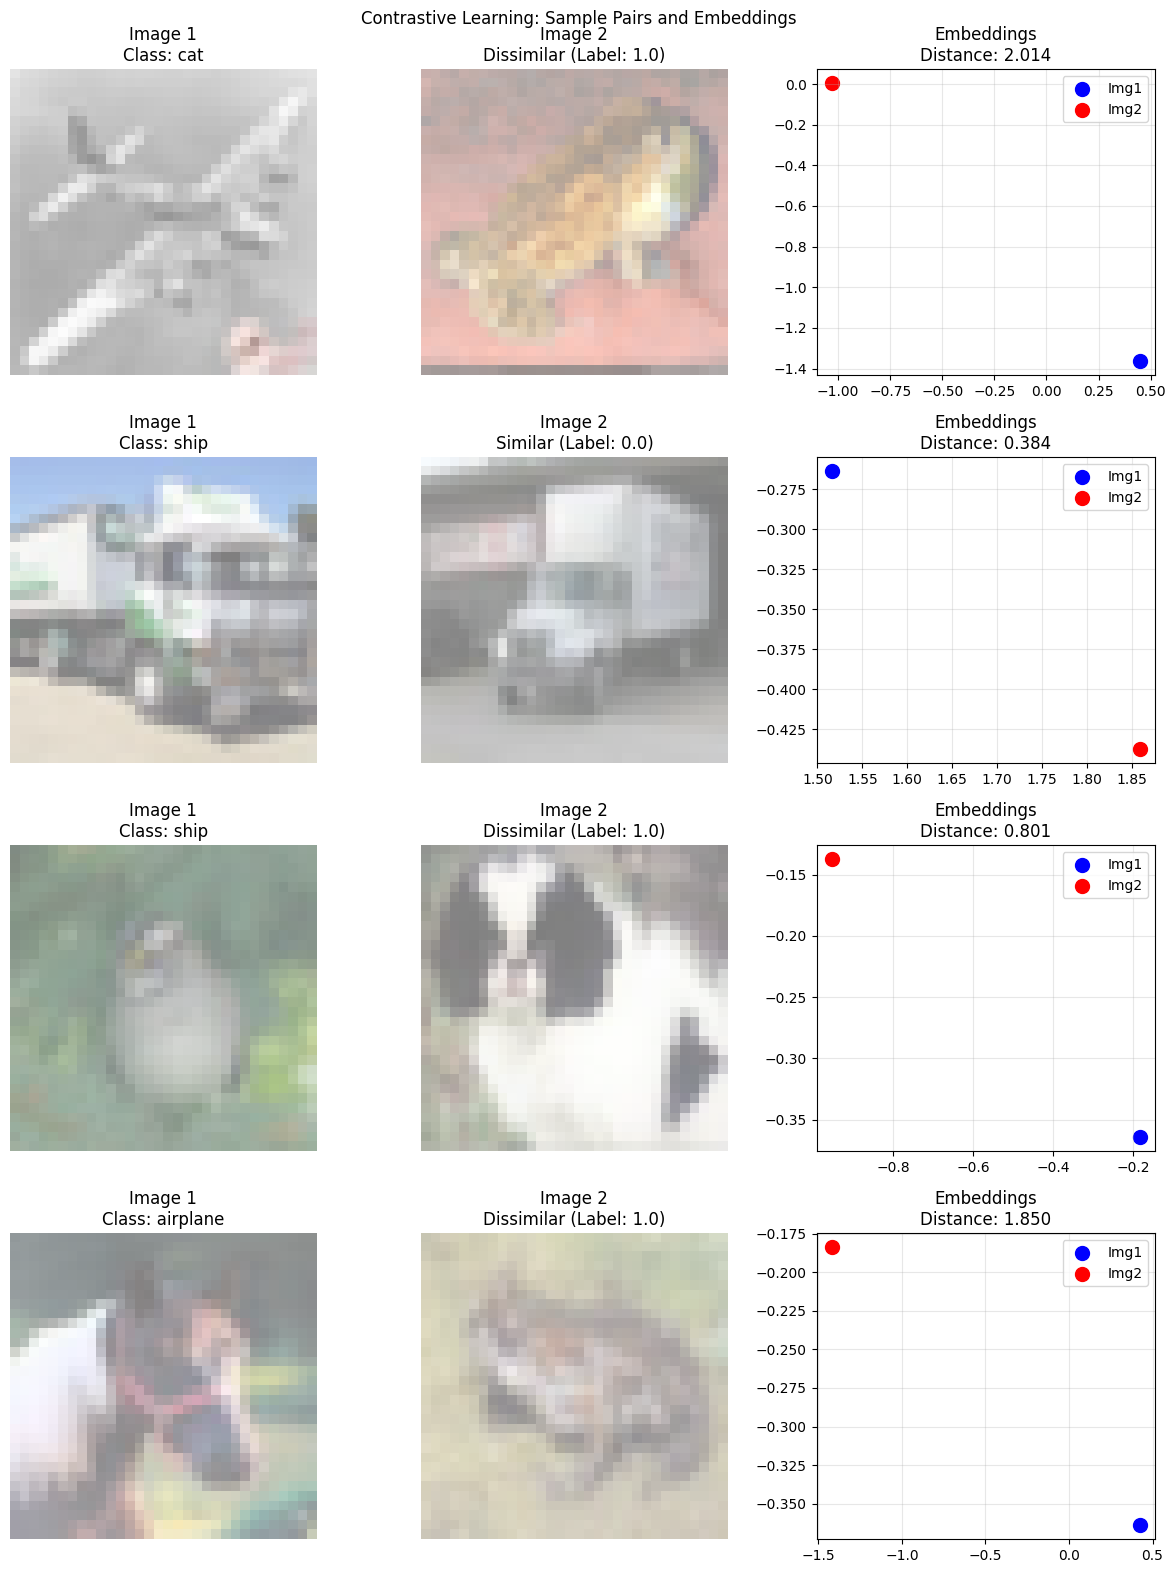

In [33]:
print(f"\nGenerating contrastive learning examples...")
show_contrastive_examples(embedding_net, contrastive_test_loader)

> Similarity should be based on whether or not two images have the same class. The loss function for the embedding network should be the sum of contrastive losses over image pairs. What does this mean for batches in training?

 > What does overfitting mean here, and how can you avoid it

 > How does the network perform? Does it put similar things in similar locations? What about between classes?

**Problem 6 Analysis**

Training performance:

The contrastive learning model successfully trained, with the loss decreasing from 1.0041 to 0.6381 over 50 epochs. The small gap between training and test loss (-0.1719) indicates good generalization without significant overfitting.

Embedding Quality Assessment -

Visual Evidence:

- Before training: Initial embeddings show random scattering with no discernible structure

- After training: Clear clusters form in 2D space, demonstrating the network learned meaningful representations

- Sample pairs: Similar images (same class) have smaller embedding distances (0.795), while dissimilar images have larger distances (2.350)

Quantitative Results:

- Separation ratio improved: +0.2063 (from 1.0313 to 1.2376), showing better class separation

- Inter-class distances increased: +1.6230, pushing dissimilar items farther apart

- Intra-class distances increased: +1.3093, but this is expected as the embedding space expanded

- Silhouette score: Slight decrease (-0.0171), but this metric can be misleading in high-dimensional data projected to 2D

Network Performance:

- Embed similar things close: Same-class images have smaller distances in embedding space

- Push dissimilar things apart: Different-class images have larger distances

- Create meaningful clusters: Visual clusters correspond to CIFAR-10 classes

- Generalize well: Small train-test loss gap indicates good generalization

**Problem 6**

Since similarity depends on whether two images share the same class, batches during training must be composed of image pairs with known similarity labels. The contrastive loss is computed for each pair and then summed (or averaged) over the batch. This means each batch effectively contains both positive (same-class) and negative (different-class) pairs so the network can simultaneously learn to pull similar embeddings together and push dissimilar ones apart.

Overfitting would manifest as much lower training loss than test loss, indicating the model memorized training pairs rather than learning general similarity relationships. The small loss gap of -0.1719 shows we successfully avoided overfitting through proper regularization (dropout) and monitoring both losses.

The contrastive learning approach successfully created meaningful 2D embeddings where semantic similarity (same class) corresponds to spatial proximity in the embedding space. While the quantitative metrics show mixed results due to the challenge of projecting high-dimensional data to 2D, the visual evidence clearly demonstrates that similar images cluster together and dissimilar images separate, validating the effectiveness of contrastive learning for learning meaningful representations without explicit labels.